In [1]:
# EE569 Homework Assignment #5
# Date: April 7, 2019
# Name: Nazim Shaikh
# ID: 8711456229
# email: nshaikh@usc.edu

#import Libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

### Initialize parameters

In [2]:
lr = 0.001
num_epochs = 25
batch_size = 128

#### torchvision is a package created for operating on images. It has data loaders for various common datasets such as CIFAR10, MNIST,etc. along with data transformers for images viz, torchvision.datasets and torch.utils.data.Dataloader

#### Output of torchvision datasets are PIL images of range [0,1]. So, we need to convert them in to tensors of normalized range [-1,1]

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True, num_workers=1)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle=True, num_workers=1)

0it [00:00, ?it/s]

9920512it [00:01, 8764883.03it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 136132.89it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2230121.66it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 51729.69it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


### Define LeNet5 Network

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #1 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16*4*4,120)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120,80)
        self.fc2_bn = nn.BatchNorm1d(80)
        self.fc3 = nn.Linear(80,10)
    
    def forward(self,x):
        x = self.pool(self.conv1_bn(f.relu(self.conv1(x))))
        x = self.pool(self.conv2_bn(f.relu(self.conv2(x))))
        
        # If the size is a square you can only specify a single number
        x = x.view(-1,16*4*4)
        
        x = self.fc1_bn(f.relu(self.fc1(x)))
        x = self.fc2_bn(f.relu(self.fc2(x)))
        x = self.fc3(x)
        return f.softmax(x)

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc1_bn): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc2_bn): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)


### Initialize weights using Xavier Initialization

In [5]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
net.apply(init_weights)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc1_bn): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc2_bn): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)

### Define loss function and optimizer

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr)
if torch.cuda.is_available():
    criterion = criterion.cuda()

### Training the network

In [7]:
train_acc = []
test_acc = []
for epoch in range(num_epochs):
    if torch.cuda.is_available():
        net = net.cuda()
    for i,  (inputs, labels) in enumerate(trainloader):
        
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(),labels.cuda()
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    
    train_correct = 0
    train_total = 0
    net = net.cpu()
    with torch.no_grad():
        for (images, labels) in trainloader:
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
        train_accuracy = (100*train_correct)/(train_total)
        train_acc.append(train_accuracy)
    
        correct = 0
        total = 0
        net = net.cpu()
        for (images, labels) in testloader:
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = (100*correct)/(total)
    test_acc.append(test_accuracy)
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%,  Test Accuracy: {test_accuracy:.2f}%")    


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/25], Train Accuracy: 98.07%,  Test Accuracy: 98.20%
Epoch [2/25], Train Accuracy: 98.68%,  Test Accuracy: 98.71%
Epoch [3/25], Train Accuracy: 98.96%,  Test Accuracy: 98.75%
Epoch [4/25], Train Accuracy: 99.08%,  Test Accuracy: 98.69%
Epoch [5/25], Train Accuracy: 99.04%,  Test Accuracy: 98.65%
Epoch [6/25], Train Accuracy: 99.10%,  Test Accuracy: 98.60%
Epoch [7/25], Train Accuracy: 99.23%,  Test Accuracy: 98.75%
Epoch [8/25], Train Accuracy: 99.33%,  Test Accuracy: 99.00%
Epoch [9/25], Train Accuracy: 99.50%,  Test Accuracy: 99.08%
Epoch [10/25], Train Accuracy: 99.42%,  Test Accuracy: 98.91%
Epoch [11/25], Train Accuracy: 99.50%,  Test Accuracy: 99.08%
Epoch [12/25], Train Accuracy: 99.49%,  Test Accuracy: 98.98%
Epoch [13/25], Train Accuracy: 99.53%,  Test Accuracy: 98.97%
Epoch [14/25], Train Accuracy: 99.53%,  Test Accuracy: 98.94%
Epoch [15/25], Train Accuracy: 99.61%,  Test Accuracy: 98.85%
Epoch [16/25], Train Accuracy: 99.58%,  Test Accuracy: 98.96%
Epoch [17/25], Tr

### Epoch-Accuracy Plot

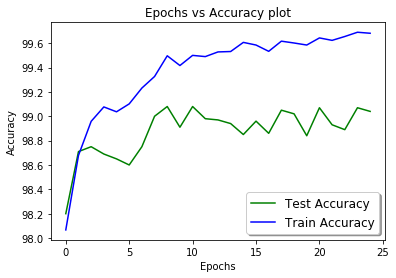

In [8]:
plt.plot(test_acc, color='green', label='Test Accuracy')
plt.plot(train_acc, color='blue', label='Train Accuracy')
plt.legend(loc='lower right', shadow=True, fontsize='large')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy plot')
plt.show()

### Evaluate Network on train data

In [9]:
correct = 0
total = 0
net = net.cpu()
with torch.no_grad():
    for (images, labels) in trainloader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Final train accuracy of the network is: {(correct/total)*100:.2f}%')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Final train accuracy of the network is: 99.69%


### Evaluate Network on test data

In [29]:
correct = 0
total = 0
net = net.cpu()
target = []
pred = []
with torch.no_grad():
    for (images, labels) in testloader:
        outputs = net(images)
        target.append(labels.reshape(-1,1))
        _, predicted = torch.max(outputs.data, 1)
        pred.append(predicted.reshape(-1,1))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Final test accuracy of the network is: {(correct/total)*100:.2f}%')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Final test accuracy of the network is: 99.08%


In [30]:
target = np.vstack(target)
target.shape 

(10000, 1)

In [31]:
pred = np.vstack(pred)
pred.shape

(10000, 1)

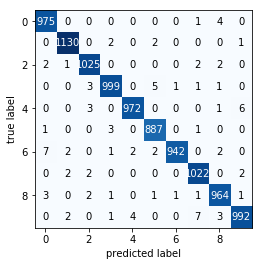

In [37]:
from mlxtend.evaluate import confusion_matrix 
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_target=target, 
                      y_predicted=pred, 
                      binary=False)

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.savefig('bp_cm.png')
plt.show()